In [40]:
from sklearn.model_selection import train_test_split

from sklearn.model_selection import StratifiedKFold

import pandas as pd
import numpy as np

import spacy

from sklearn.metrics import  roc_auc_score, roc_curve, auc, confusion_matrix

import tqdm


import seaborn as sns
import matplotlib.pyplot as plt

from utils import  deserialize_doc

import pickle

from spacy.tokens import Doc

from collections import Counter

from keras import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping

read data

In [3]:
df = pd.read_csv('./all_feats_for_analysis.csv')

In [4]:
with open('./tickers.txt', 'r') as f:
    ticker_list = [t.strip() for t in f.readlines()]

In [5]:
vocab = spacy.vocab.Vocab().from_disk('vocab.txt')
docs = []
progress_bar = tqdm.tqdm()

with open('docs.bin', 'rb') as f:
    while True:
        try:
            docs.append(deserialize_doc(pickle.load(f), vocab))
        except EOFError:
            break
        progress_bar.update(1)

df.loc[:, 'doc'] = docs

245099it [01:10, 5154.88it/s]

## Doc preprocessing

**cut the doc**

In [6]:
PAD = 'PAD'

def cut_doc(doc, position, n=4):
    """this function cuts n tokens on the left and n tokens on the right sides
        of ticker candidate position
        if there is no token there, then pad the sequence with PAD-token
        input:
            * doc
            * position
            * n 
        output:
            list of words with the length 2 * n + 1
    """
    a = position - n
    b = position + n + 1
    
    if a < 0:
        a_pad = abs(a)
        a = 0
    else:
        a_pad = 0
    
    if b > len(doc):
        b_pad = b - len(doc)
    else:
        b_pad = 0
    
    return [PAD] * a_pad + list(map(lambda x: x.text.lower(), doc[a:b])) + [PAD] * b_pad

In [7]:
doc_cuts = []

for doc, pos in df.loc[:, ['doc', 'position']].values:
    doc_cuts.append(cut_doc(doc, pos))

**after cutting docs `74k` unique tokens left**

In [8]:
words_cnt = Counter()

for d in doc_cuts:
    words_cnt.update(d)

In [9]:
len(words_cnt)

74676

**choosing cutoff for affordable amount of unique words**

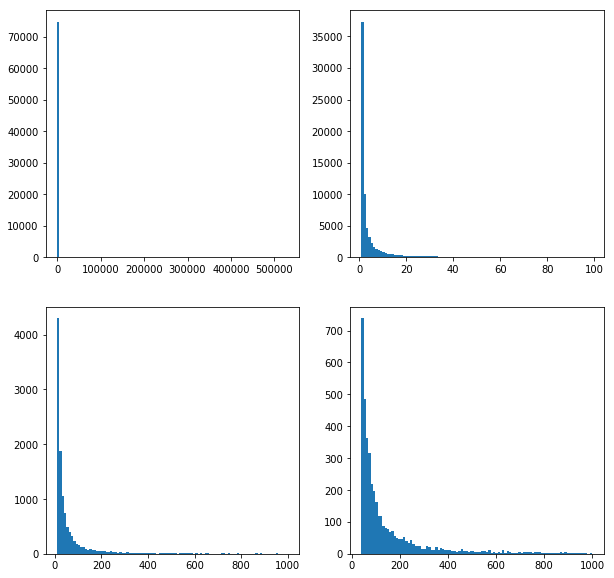

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0,0].hist(words_cnt.values(), bins=100, label='all word cnts');
axs[0,1].hist(list(filter(lambda x:  x < 100, words_cnt.values())), bins=100);
axs[1,0].hist(list(filter(lambda x: x > 10 and x < 1000, words_cnt.values())), bins=100);
axs[1,1].hist(list(filter(lambda x: x > 40 and x < 1000, words_cnt.values())), bins=100);
plt.show()

**The most optimal way is to keep 4k words. These are words that have met at least 40 times**

In [11]:
words = set(map(lambda x: x[0], filter(lambda x: x[1] > 40, words_cnt.items())))

In [13]:
len(words)

4291

In [14]:
words_mapping = dict(zip(words, range(len(words))))

assign one more int number for words that are too rare

In [15]:
NOP_INDEX = len(words) + 1

def encode_doc(doc):
    return np.array([words_mapping.get(x, NOP_INDEX) for x in doc], dtype=np.int32)

**encoding docs**

In [16]:
docs_encoded = list(map(encode_doc, doc_cuts))
df['doc_encoded'] = docs_encoded

**get the TRAIN and TEST data**

In [17]:
TRAIN, TEST, y_label_train, y_label_test = train_test_split(
                                                            df, 
                                                            df['label'], 
                                                            test_size=0.2, 
                                                            random_state=3, 
                                                            stratify=df['label']
                                                        )

TRAIN.reset_index(inplace=True, drop=True)
TEST.reset_index(inplace=True, drop=True)
y_label_train.reset_index(inplace=True, drop=True)
y_label_test.reset_index(inplace=True, drop=True)

**TRAIN-data is split into Train and Validation sets**

In [18]:
X_train, X_val, y_train, y_val = train_test_split(
                                                            TRAIN, 
                                                            TRAIN['label'], 
                                                            test_size=0.3, 
                                                            random_state=3, 
                                                            stratify=TRAIN['label']
                                                        )

X_train.reset_index(inplace=True, drop=True)
X_val.reset_index(inplace=True, drop=True)
y_train.reset_index(inplace=True, drop=True)
y_val.reset_index(inplace=True, drop=True)

In [19]:
def get_model():
    """returns the model"""
    model = Sequential()
    model.add(Embedding(len(words) + 1, 32))
    model.add(Bidirectional(LSTM(16)))
    model.add(Dropout(0.75))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
    )
    
    return model

In [20]:
!rm -rf checkpoints
!mkdir -p checkpoints

In [24]:
checkpoint_path = 'checkpoints/checkpoint_epoch_{epoch:02d}_acc_{acc:.4f}_val_acc_{val_acc:.4f}.bin'
checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_acc',
    save_best_only=True
)
early_stopping = EarlyStopping(monitor='val_acc', patience=5)

In [25]:
model = get_model()
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          137344    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 32)                6272      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 143,649
Trainable params: 143,649
Non-trainable params: 0
_________________________________________________________________
None


In [26]:
history = model.fit(
    np.vstack(X_train['doc_encoded']), y_train,
    validation_data=(np.vstack(X_val['doc_encoded']), y_val),
    epochs=20,
    batch_size=64,
    callbacks=[checkpoint, early_stopping]
)

Instructions for updating:
Use tf.cast instead.
Train on 137255 samples, validate on 58824 samples
Epoch 1/20
137255/137255 [==============================] - 45s 331us/step - loss: 0.2132 - acc: 0.9131 - val_loss: 0.1526 - val_acc: 0.9382
Epoch 2/20
137255/137255 [==============================] - 36s 261us/step - loss: 0.1514 - acc: 0.9426 - val_loss: 0.1425 - val_acc: 0.9435
Epoch 3/20
137255/137255 [==============================] - 36s 260us/step - loss: 0.1328 - acc: 0.9495 - val_loss: 0.1340 - val_acc: 0.9481
Epoch 4/20
137255/137255 [==============================] - 36s 260us/step - loss: 0.1201 - acc: 0.9547 - val_loss: 0.1363 - val_acc: 0.9474
Epoch 5/20
137255/137255 [==============================] - 36s 260us/step - loss: 0.1099 - acc: 0.9577 - val_loss: 0.1474 - val_acc: 0.9498
Epoch 6/20
137255/137255 [==============================] - 36s 260us/step - loss: 0.1027 - acc: 0.9609 - val_loss: 0.1414 - val_acc: 0.9495
Epoch 7/20
137255/137255 [=============================

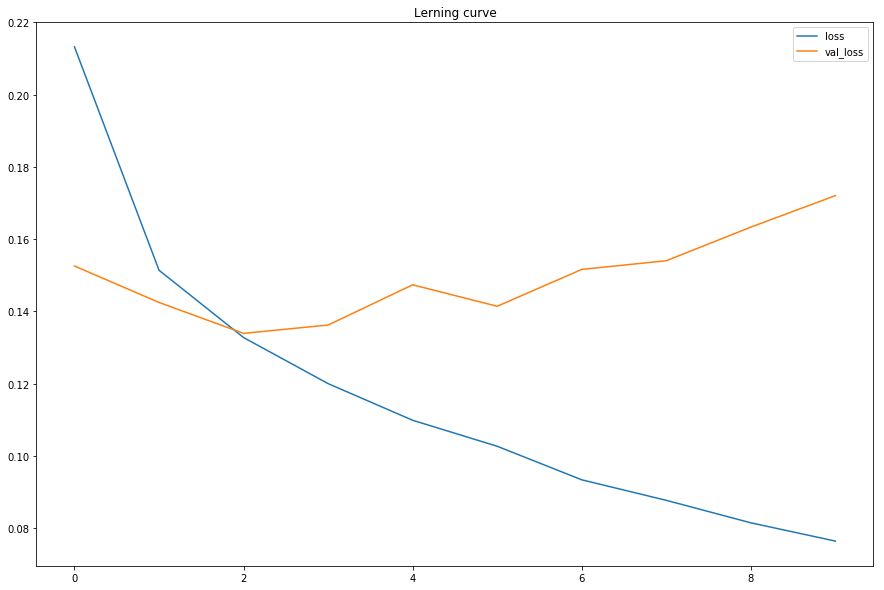

In [29]:
plt.figure(figsize=(15,10))

for y in ('loss', 'val_loss'):
    plt.plot(history.epoch, history.history[y], label=y)

plt.title('Lerning curve')
plt.legend()
plt.show()

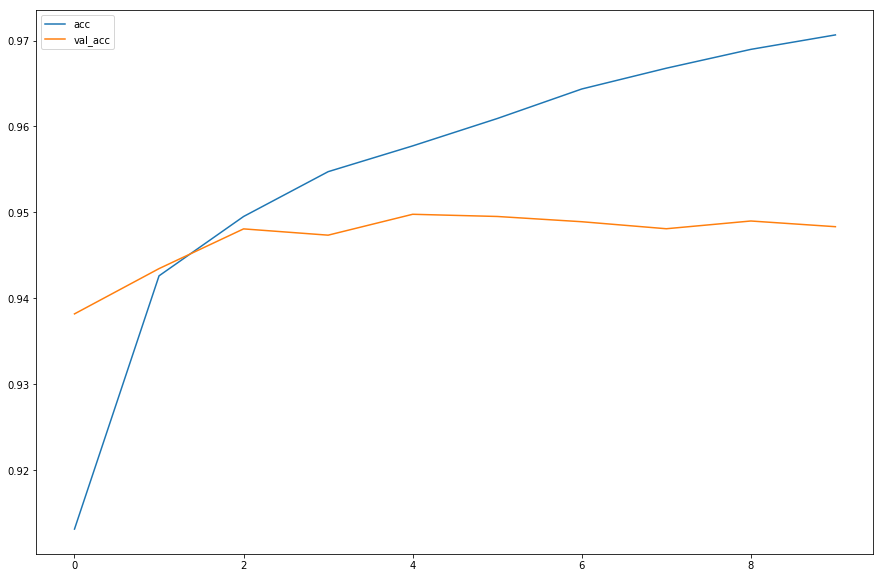

In [28]:
plt.figure(figsize=(15,10))

for y in ('acc', 'val_acc'):
    plt.plot(history.epoch, history.history[y], label=y)

plt.title('Accuracy curve')
plt.legend()
plt.show()

**The best score was obtained on the 2nd epoch**

In [30]:
!ls checkpoints

checkpoint_epoch_01_acc_0.9131_val_acc_0.9382.bin
checkpoint_epoch_02_acc_0.9426_val_acc_0.9435.bin
checkpoint_epoch_03_acc_0.9495_val_acc_0.9481.bin
checkpoint_epoch_05_acc_0.9577_val_acc_0.9498.bin


In [31]:
model.load_weights('checkpoints/checkpoint_epoch_02_acc_0.9426_val_acc_0.9435.bin')

In [32]:
p_test = model.predict(np.vstack(TEST['doc_encoded']))

(49020, 1)

In [33]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_label_test, p_test)

0.9869660333799991

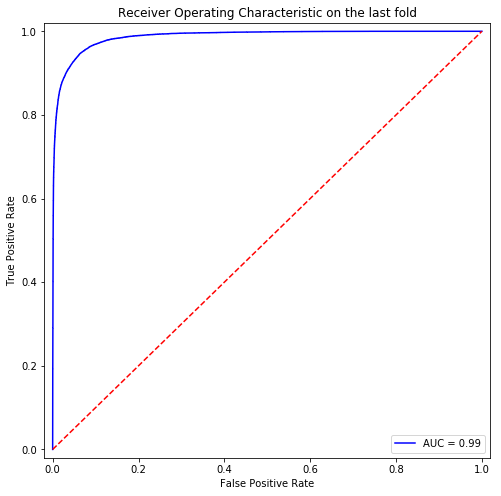

In [38]:
fpr, tpr, threshold = roc_curve(y_label_test, p_test)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.title('Receiver Operating Characteristic on the last fold')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [41]:
m = confusion_matrix(y_label_test, p_test > 0.5)
m1 = m / m.sum(axis=0)

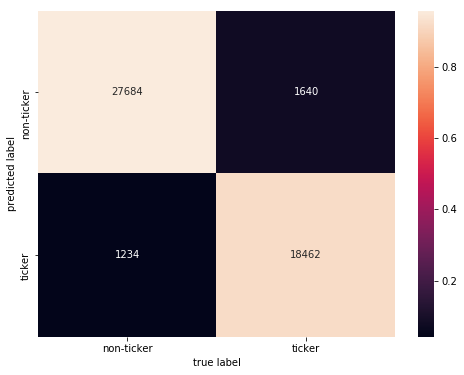

In [42]:
plt.figure(figsize=(8,6))
sns.heatmap(m1, annot=m, 
            xticklabels=['non-ticker', 'ticker'], 
            yticklabels=['non-ticker', 'ticker'],
            fmt='g'
           )
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()